<font color='red'>

##### the purpose of this script is to collate together the findings on how tuning curve precision is modulated by aspects of physiology - namely, how tuning curve precision is related to posterior alpha power, and to pupil size, prior to the onset of a stimulus

</font>

In [91]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import os.path as op
import sys
from matplotlib import pyplot as plt

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    funcdir    = op.join(wd, 'analysis', 'tools')
    sys.path.insert(0, funcdir)
os.chdir(wd)
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
from funcs import getSubjectInfo, clusterperm_test

eyedir = op.join(wd, 'data', 'eyes')
bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
eegsubs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26]) #eeg ppts
eyesubs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26]) # eyetracking ppts

#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy')), 2)
print(f'{eegsubs.size} participants are included in eeg-based analyses')
print(f'{eyesubs.size} participants are included in pupil-based analyses')

20 participants are included in eeg-based analyses
16 participants are included in pupil-based analyses


In [92]:
#load in the relevant datasets here
precision = np.zeros(shape = [eegsubs.size, modeltimes.size]) * np.nan
binstep, binwidth, weightTrials = 4, 22, True
subcount = -1
for i in eegsubs:
    subcount +=1
    iprec = np.load(op.join(wd, 'data', 'tuningcurves', 'parameter_fits', 'twostage_alphaminmaxfit_b1desmatminmax',
                f's{i}_ParamFits_precision_binstep{binstep}_binwidth{binwidth}_smoothedprec.npy'))
    
    precision[subcount] = np.nanmean(iprec, axis=1).mean(0) #average across trials, then average across items
print('loaded in tuning curve precision data across participants')
mean_prec = precision.mean(0)
sem_prec  = sp.stats.sem(precision, axis=0, ddof=0, nan_policy='omit')

loaded in tuning curve precision data across participants


In [93]:
#load in the pupil data
use_b = True #whether or not the single-trial parameter estimate (beta) or its t-value is used in the participant GLM
if use_b:
    paramind = 0
    addtext = 'modelAmplitudeBeta'
elif not use_b:
    paramind = 1
    addtext = 'modelAmplitudeTvalue'
fittype = 'glm' #whether to use the amplitude estimate that is fit using a GLM or using an optimisation routine
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'

eyetimes   = np.round(np.load(op.join(wd, 'data', 'glms', 'glm3', 'eyetracker_times.npy')), 2)
eyeregnames   = np.load(op.join(wd, 'data', 'glms', 'glm3', 'regressor_names.npy'))
nparams = eyeregnames.size
#ppts x tuning curve timepoints x regressors x
eyeb = np.zeros(shape = [eyesubs.size, nparams, modeltimes.size, eyetimes.size]) * np.nan
eyet = np.zeros(shape = [eyesubs.size, nparams, modeltimes.size, eyetimes.size]) * np.nan

subcount = -1
for sub in eyesubs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'glm3', f'wmc_s{sub:02d}_glm3_betas_{fittext}_{addtext}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', 'glm3', f'wmc_s{sub:02d}_glm3_tvalues_{fittext}_{addtext}.npy'))
    eyeb[subcount] = ib.copy()
    eyet[subcount] = it.copy()
print('loaded in pupillometry data across participants')

loaded in pupillometry data across participants


In [94]:
eegtimes    = np.round(np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', 'eeg_times.npy')), 2)
eegregnames = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', 'regressor_names.npy'))
nparams     = eegregnames.size

eegb = np.zeros(shape = [eegsubs.size, nparams, modeltimes.size, eegtimes.size]) * np.nan
eegt = np.zeros(shape = [eegsubs.size, nparams, modeltimes.size, eegtimes.size]) * np.nan

use_b = True #whether or not the single-trial parameter estimate (beta) or its t-value is used in the participant GLM
if use_b:
    paramind = 0
    addtext = 'modelAmplitudeBeta'
elif not use_b:
    paramind = 1
    addtext = 'modelAmplitudeTvalue'
fittype = 'glm' #whether to use the amplitude estimate that is fit using a GLM or using an optimisation routine
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'

#use a model that predicts log-transformed power (10*log10) so looking at decibels
logdata = True
if logdata:
    logtxt = '_logpower'
else:
    logtxt = ''

# use the output froma  model that uses lightly smoothed amplitude estimates across time? reduces some noise at single trial level
smoothamp = True
if smoothamp:
    #smoothed amplitude estimate lightly over time   
    amptxt = '_smoothamp'
elif not smoothamp:
    amptxt = ''

subcount = -1
for sub in eegsubs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', f'wmc_s{sub:02d}_glm2{logtxt}_betas_{fittext}_{addtext}{amptxt}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm2', f'wmc_s{sub:02d}_glm2{logtxt}_tvalues_{fittext}_{addtext}{amptxt}.npy'))
    eegb[subcount] = ib.copy()
    eegt[subcount] = it.copy()
print('loaded in eeg alpha data across participants')

loaded in eeg alpha data across participants


stat_fun(H1): min=-2.445681737956796 max=1.676031248782305
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 14299.77it/s]

cluster p-values for alpha: [0.0653 0.3004 0.282  0.2166]
stat_fun(H1): min=-2.558426253944721 max=1.5262869329855944
Running initial clustering …
Found 3 clusters



100%|██████████| Permuting : 9999/9999 [00:00<00:00, 14915.90it/s]


cluster p-values for pupil size: [0.3734 0.3227 0.0214]
cluster forming window for analysis: 0s < time < 0.75s


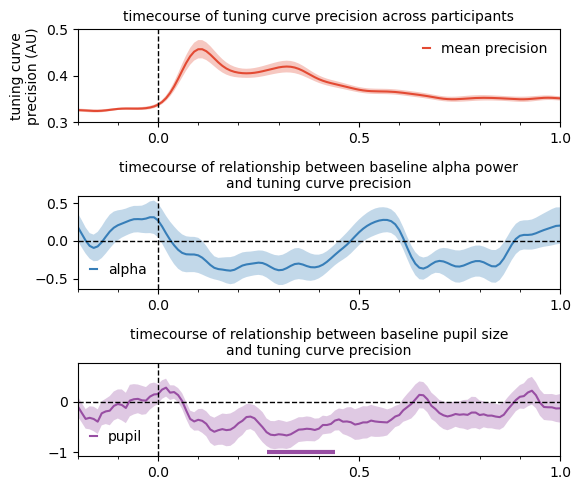

In [95]:
np.random.seed(420)
#visualise main effect, pupil effect and alpha effect in the same figure
eegtmin, eegtmax = -0.5, -0.15 #time window that accounts for the width of the frequency estimation window so there's no leakage of post-stimulus information into the baseline period
eyetmin, eyetmax = -0.3, 0 #don't have the same issue with pupillometry really

fig = plt.figure(figsize = [6,5])
ax1 = fig.add_subplot(311)
ax1.plot(modeltimes, mean_prec, lw = 1.5, color = '#e34a33', label = 'mean precision')
ax1.fill_between(modeltimes, np.add(mean_prec, sem_prec), np.subtract(mean_prec, sem_prec), lw = 0, edgecolor=None, color = '#e34a33', alpha = 0.3)
ax1.set_ylabel('tuning curve\nprecision (AU)')
ax1.set_title('timecourse of tuning curve precision across participants', fontsize=10)

ax2 = fig.add_subplot(312)
tinds = np.logical_and(eegtimes >= eegtmin, eegtimes <= eegtmax)
eegdat = eegt[:,:,:, tinds].mean(-1) #average across times in the eeg alpha dimension
eegparam = np.where(eegregnames == 'precision')[0].squeeze()
ploteegdat = eegdat[:, eegparam]
meeg, semeeg = ploteegdat.mean(0), sp.stats.sem(ploteegdat, axis=0, ddof=0, nan_policy='omit')
ax2.plot(modeltimes, meeg, lw = 1.5, color = '#377eb8', label = 'alpha')
ax2.fill_between(modeltimes, np.add(meeg, semeeg), np.subtract(meeg, semeeg), lw = 0, edgecolor = None, color = '#377eb8', alpha = 0.3)
ax2.axhline(0, lw = 1, ls = 'dashed', color='k')
ax2.set_title('timecourse of relationship between baseline alpha power\nand tuning curve precision', fontsize=10)

ax3 = fig.add_subplot(313)
tinds = np.logical_and(eyetimes >= eyetmin, eyetimes <= eyetmax)
eyeparam = np.where(eyeregnames == 'precision')[0].squeeze()
eyedat = eyet[:,:,:,tinds].mean(-1) #average across times in the pupil dimension
ploteyedat = eyedat[:,eyeparam]
meye, semeye = ploteyedat.mean(0), sp.stats.sem(ploteyedat, axis=0, ddof=0, nan_policy='omit')
ax3.plot(modeltimes, meye, lw = 1.5, color = '#984ea3', label = 'pupil')
ax3.fill_between(modeltimes, np.add(meye, semeye), np.subtract(meye, semeye), lw = 0, edgecolor = None, color = '#984ea3', alpha = 0.3)
ax3.axhline(0, lw = 1, ls = 'dashed', color = 'k')
ax3.set_title('timecourse of relationship between baseline pupil size\nand tuning curve precision', fontsize=10)
axcount=0
for ax in [ax1, ax2, ax3]:
    axcount +=1
    if axcount > 1:
        loc = 'lower left'
    else:
        loc = 'upper right'
    ax.axvline(0, ls = 'dashed', lw = 1, color='k')
    ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.set_xlim([-0.2, 1])
    ax.legend(frameon=False, loc = loc, handlelength = 0.5)
ax1.set_ylim([0.3, 0.5])
# ax2.set_ylim([-0.7, 0.7])
# ax3.set_ylim([-1, 1])

#run cluster permutation stats on the relevant timeseries, get params for cluster forming
sigalpha = 0.05
#get thresholds based on number of participants in the modality-specific dataset
eeg_t_thresh = sp.stats.t.ppf(1-sigalpha, df = eegsubs.size - 1) 
eye_t_thresh = sp.stats.t.ppf(1-sigalpha, df = eyesubs.size - 1)
tmin, tmax = 0, 0.75
nperms = 10000#'all' #just do 10k permutations to begin with

run_clusterstats = True
if run_clusterstats:
    #cluster stats on alpha ~ precision timecourse
    tv, clu, clupv, _ = clusterperm_test(data = eegdat, labels = eegregnames, of_interest = 'precision', times = modeltimes, 
                                         tmin = tmin, tmax = tmax, out_type='indices', n_permutations = nperms,
                                         threshold = -eeg_t_thresh, tail = -1, n_jobs = 4)
    clu = [x[0] for x in clu]
    print(f'cluster p-values for alpha: {clupv}')
    times_twin = modeltimes[np.logical_and(modeltimes >= tmin, modeltimes <= tmax)]
    nclus = len(clu)
    for icluster in range(nclus):
        mask = clu[icluster]
        if clupv[icluster] <= sigalpha:
            itmin, itmax = times_twin[mask[0]], times_twin[mask[-1]]
            ax2.hlines(y = -0.6, xmin = itmin, xmax = itmax, lw = 3, color = '#377eb8', alpha = 1)
    
    #cluster stats on pupil ~ precision timecourse
    tv, clu, clupv, _ = clusterperm_test(data = eyedat, labels = eyeregnames, of_interest = 'precision', times = modeltimes, 
                                         tmin = tmin, tmax = tmax, out_type='indices', n_permutations = nperms,
                                         threshold = -eye_t_thresh, tail = -1, n_jobs = 4)
    clu = [x[0] for x in clu]
    print(f'cluster p-values for pupil size: {clupv}')
    times_twin = modeltimes[np.logical_and(modeltimes >= tmin, modeltimes <= tmax)]
    nclus = len(clu)
    for icluster in range(nclus):
        mask = clu[icluster]
        if clupv[icluster] <= sigalpha:
            itmin, itmax = times_twin[mask[0]], times_twin[mask[-1]]
            ax3.hlines(y = -1, xmin = itmin, xmax = itmax, lw = 3, color = '#984ea3', alpha = 1)
print(f'cluster forming window for analysis: {tmin}s < time < {tmax}s')
fig.tight_layout()